# First 6hr Sun observation analysis

In [1]:
import ugradio
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.table as Table
from datetime import datetime
from datetime import timedelta
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy

%matplotlib inline
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

No module named 'rtlsdr'


## Loading in the data

Data was collected on March 22, 2022 beginning at 8:27:25 am and ending on 2:26:52 pm (PST).

In [2]:
volts, times = np.load('Data/6hr_Sun_data.npy')

times = times[0:13500]
volts = volts[0:13500]

### Getting the times of observation in PST and JD:

In [3]:
### Getting initial times ###

beginning_time = min(times)
ending_time = max(times)

beginning_local_time = ugradio.timing.local_time(beginning_time)
ending_local_time = ugradio.timing.local_time(ending_time)

beginning_jd = ugradio.timing.julian_date(beginning_time)
ending_jd = ugradio.timing.julian_date(ending_time)


print('Beginning time in local time (PST):', beginning_local_time, '\nEnding time in local time (PST):', ending_local_time)

print('\nBeginning JD:', beginning_jd, '\nEnding JD:', ending_jd)

# beginning_local_time[11:19]

Beginning time in local time (PST): Tue Mar 22 08:27:25 2022 
Ending time in local time (PST): Tue Mar 22 11:49:54 2022

Beginning JD: 2459661.14404817 
Ending JD: 2459661.284662759


In [4]:
### Latitude and Longitude of Observations ###

lon, lat = ugradio.coord.nch.lon, ugradio.coord.nch.lat

In [5]:
### JDs, LSTs, initial ra and dec, hour angles ###

jds = ugradio.timing.julian_date(times) # julian dates
LSTs = ugradio.timing.lst(jd=jds, lon=lon) # local sidereal times -- radians

ra_deg, dec_deg = ugradio.coord.sunpos(beginning_jd) # initial ra and dec, degrees
ra_rad, dec_rad = (np.pi/180)*ra_deg, (np.pi/180)*dec_deg #radians
has = LSTs - ra_rad # hour angles -- radians

## Looking for Fringes

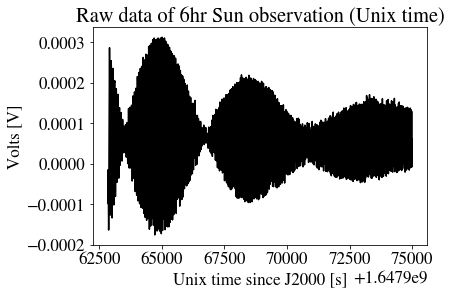

In [6]:
plt.figure()
plt.title('Raw data of 6hr Sun observation (Unix time)')
plt.plot(times, volts, 'k')
# plt.vlines(times[11500], min(volts), max(volts), 'r', zorder=5)
plt.xlabel('Unix time since J2000 [s]')
plt.ylabel('Volts [V]')
plt.show()

In [7]:
v_inter = np.median(np.diff(times))

freqs = np.fft.fftfreq(len(times), v_inter)

power = np.abs(np.fft.fft(volts))**2

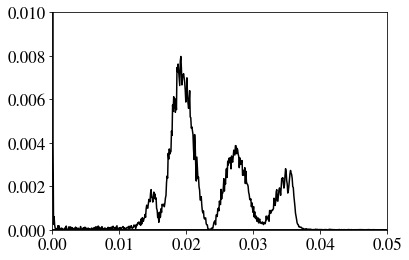

In [8]:
plt.figure()
plt.plot(freqs, power, 'k')
plt.xlim(0,0.05)
plt.ylim(0,0.01)
plt.show()

In [9]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))


def split_data(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        dt = np.mean(np.diff(time_frac))
        frequency = freq(time_frac, dt)
        pow_frac = pow_fft(data_frac)
        
        data_splits.append(pow_frac)
        freq_splits.append(frequency)
        
    return data_splits, freq_splits

In [10]:
split_power, split_freqs = split_data(volts, times, 12)

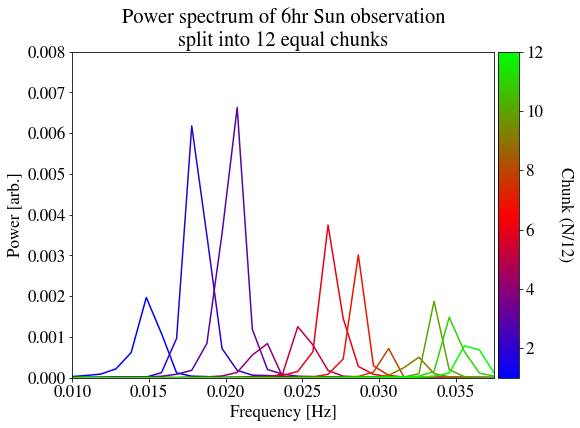

In [11]:
cmap = plt.cm.brg
n = len(split_power)
colors = cmap(np.linspace(0,1,n))


fig, ax = plt.subplots(1,1, figsize=(8,6))
plt.title('Power spectrum of 6hr Sun observation\nsplit into {0:.0f} equal chunks'.format(len(split_power)))


for i in range(len(split_power)):
    ax.plot(split_freqs[i], split_power[i], color=colors[i])
    
    
norm_scaling = mpl.colors.Normalize(vmin=min(range(len(split_power)))+1, vmax=max(range(len(split_power)))+1)
divider = axgrid.make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_scaling, cmap=cmap), cax=cax)
cbar.set_label(label= 'Chunk (N/{0:.0f})'.format(len(split_power)), rotation=270, labelpad=30)


ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power [arb.]')
ax.set_xlim(0.01, 0.0375)
ax.set_ylim(0, 0.008)
plt.show()


### Expected fringe frequencies

In [12]:
def exp_fringe_freq(hs0, dec, Bew, Bns, L):
    λ = 2.77e-2 # m
    term1 = (Bew/λ)*np.cos(dec)*np.cos(hs0) 
    term2 = (Bns/λ)*np.sin(L)*np.cos(dec)*np.sin(hs0)
    ff = term1 -  term2
    return ff

In [13]:
Bew = 20  # m
Bns = 0

lat, lon = ugradio.nch.lat, ugradio.nch.lon # degrees
L = (np.pi/180)*lat # converting to radians

α, δ = ugradio.coord.sunpos(beginning_jd) # both calculated in degrees -- ra, dec calculated at beginning of observation
α = (np.pi/180)*α # converted to radians
δ = (np.pi/180)*δ # converted to radians
# ha = α*(24/(2*np.pi)) # convert ra to hour angle (hrs)

LST = ugradio.timing.lst(beginning_jd, lon) #radians
h_s = LST - α

print('Expected fringe frequency:', exp_fringe_freq(h_s, δ, Bew, Bns, L)) ## Hz??
## off by 1e-3??

Expected fringe frequency: 225.2061217739723


# Analysis

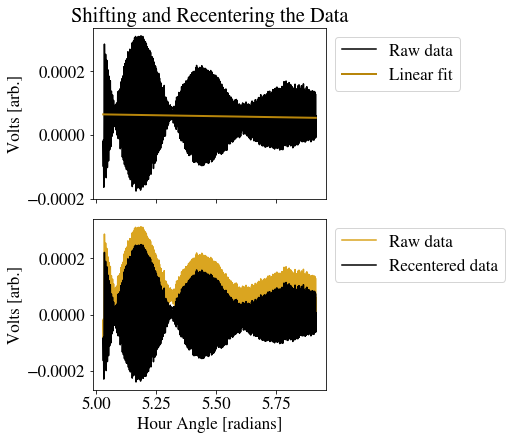

Slope: -1.2244582329655398e-05 
y-int: 0.00012666735284377602


In [14]:
### Shifting data and recentering to correct for bias ###

linear_model = np.polyfit(has, volts, deg=1)
m, b = linear_model

fig, (ax0, ax1) = plt.subplots(2,1, figsize=(7,6), constrained_layout=True, sharex=True)

ax0.set_title('Shifting and Recentering the Data')

ax0.plot(has, volts, color='k', label='Raw data')
ax0.plot(has, m*has + b, 'darkgoldenrod', lw=2, label='Linear fit')
ax0.set_ylabel('Volts [arb.]')
ax0.legend(bbox_to_anchor=(1,1), loc='upper left')

ax1.plot(has, volts, color='goldenrod', label='Raw data')
ax1.plot(has, volts - (m*has + b), color='k', label='Recentered data')
ax1.set_xlabel('Hour Angle [radians]')
ax1.set_ylabel('Volts [arb.]')
ax1.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.show()

print('Slope:', m, '\ny-int:', b)

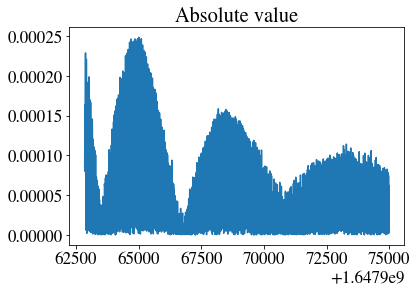

In [24]:
### Taking absolute value of shifted data ###

centered_volts = volts - (m*has + b)

abs_centered_volts = np.abs(centered_volts)

plt.figure()
plt.title('Absolute value')
plt.plot(times, abs_centered_volts)
plt.show()

In [16]:
# plt.figure()
# plt.plot(times, centered_volts, label='centered')
# plt.plot(times, abs_centered_volts, alpha=0.7, label='abs. val + centered')
# plt.legend(bbox_to_anchor=(1,1), loc='upper left')
# plt.show()

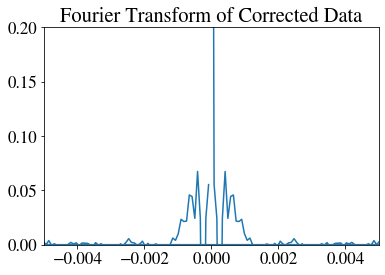

In [25]:
### FFT ###

dt = np.mean(np.diff(times))

fft_volts = np.fft.fft(abs_centered_volts)
freqs = np.fft.fftfreq(len(times), dt)

plt.figure()
plt.title('Fourier Transform of Corrected Data')
plt.plot(freqs, fft_volts)
plt.ylim(0, 0.2)
plt.xlim(-0.005, 0.005)
plt.show()

In [26]:
### Fourier Filtering ###
# The envelope exists in the low frequencies

fft_volts[np.where(freqs > 0.0025)] = 0
fft_volts[np.where(freqs < -0.0025)] = 0

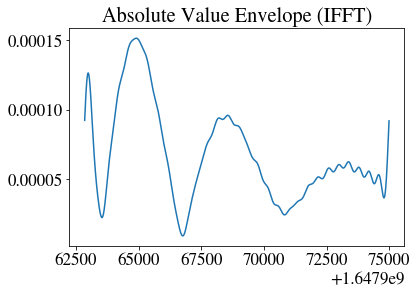

In [27]:
### Envelope ###

abs_envelope = np.fft.ifft(fft_volts)

plt.figure()
plt.title('Absolute Value Envelope (IFFT)')
plt.plot(times, abs_envelope)
plt.show()

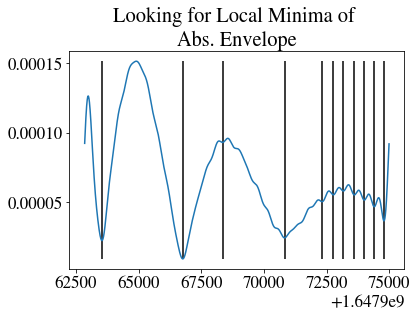

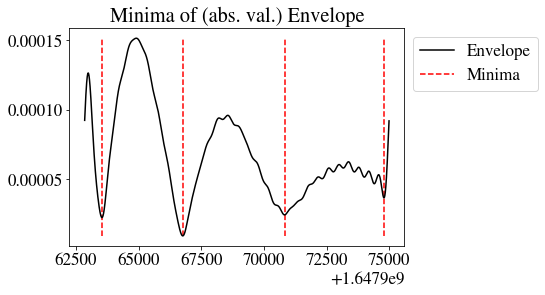

In [28]:
### Finding Local Minima of (abs.) Envelope ###

import scipy.signal as ss
local_minimum = ss.argrelmin(abs_envelope)

plt.figure()
plt.title('Looking for Local Minima of \nAbs. Envelope')
plt.plot(times, abs_envelope)
for i in range(len(local_minimum[0])):
    plt.vlines(times[local_minimum[0][i]], min(abs_envelope), max(abs_envelope))
plt.show()


local_mins = np.array([local_minimum[0][0], 
                       local_minimum[0][1], 
                       local_minimum[0][3], 
                       local_minimum[0][10]])
plt.figure()
plt.plot(times, abs_envelope, 'k')
for i in range(len(local_mins)):
    plt.vlines(times[local_mins[i]], min(abs_envelope), max(abs_envelope), 'r', linestyles='--')
labels = ['Envelope', 'Minima']
plt.legend(labels=labels, bbox_to_anchor=(1,1), loc='upper left')
plt.title('Minima of (abs. val.) Envelope')
plt.show()

In [29]:
### Changing the sign of parts of the envelope ###

chunk1 = abs_envelope[0:local_mins[0]]
chunk1 = chunk1*-1
chunk2 = abs_envelope[local_mins[0]:local_mins[1]]
chunk3 = abs_envelope[local_mins[1]:local_mins[2]]
chunk3 = chunk3*-1
chunk4 = abs_envelope[local_mins[2]:local_mins[3]]
chunk5 = abs_envelope[local_mins[3]:]
chunk5 = chunk5*-1

envelope = np.append(chunk1, chunk2)
envelope = np.append(envelope, chunk3)
envelope = np.append(envelope, chunk4)
envelope = np.append(envelope, chunk5)


times.shape, envelope.shape

((13500,), (13500,))

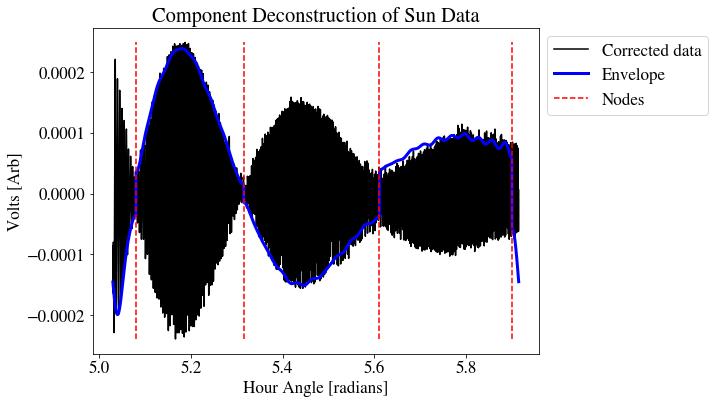

In [30]:
### Plotting Components ###

plt.figure(figsize=(8,6))
for i in range(len(local_mins)):
    plt.vlines(has[local_mins[i]], min(centered_volts), max(centered_volts), color='red', linestyles='--', zorder=6)
plt.plot(has, centered_volts, 'k')
plt.plot(has, envelope*1.575, 'b', lw=3) # arb. scaling factor applied to envelope
plt.title('Component Deconstruction of Sun Data')
plt.xlabel('Hour Angle [radians]')
plt.ylabel('Volts [Arb]')
labels = ['Corrected data', 'Envelope', 'Nodes']
plt.legend(labels=labels, bbox_to_anchor=(1,1), loc='upper left')
plt.show()

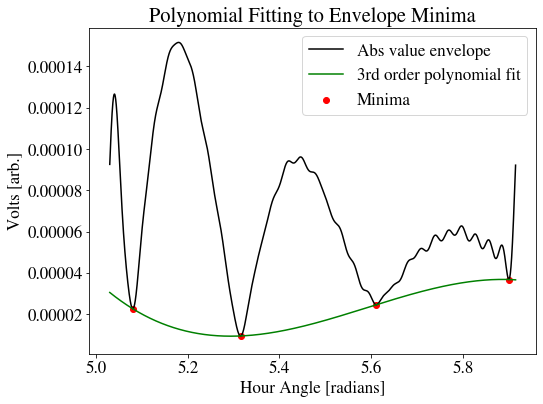

In [31]:
### Polynomial Fitting to Envelope Minima ###

plt.figure(figsize=(8,6))
plt.plot(has, abs_envelope, 'k')
for i in range(len(local_mins)):
    plt.scatter(has[local_mins[i]], abs_envelope[local_mins[i]], color='red')
plt.title('Polynomial Fitting to Envelope Minima')

has_mins = []
envelope_mins = []
for i in range(len(local_mins)):
    has_min, envelope_min = has[local_mins[i]], abs_envelope[local_mins[i]]
    has_mins.append(has_min), envelope_mins.append(envelope_min)
    
poly = np.polyfit(has_mins, envelope_mins, deg=3)
y_poly = np.polyval(poly, has)
plt.plot(has, y_poly, color='g')

plt.legend(labels=['Abs value envelope', '3rd order polynomial fit', 'Minima'])
plt.xlabel('Hour Angle [radians]')
plt.ylabel('Volts [arb.]')
plt.show()

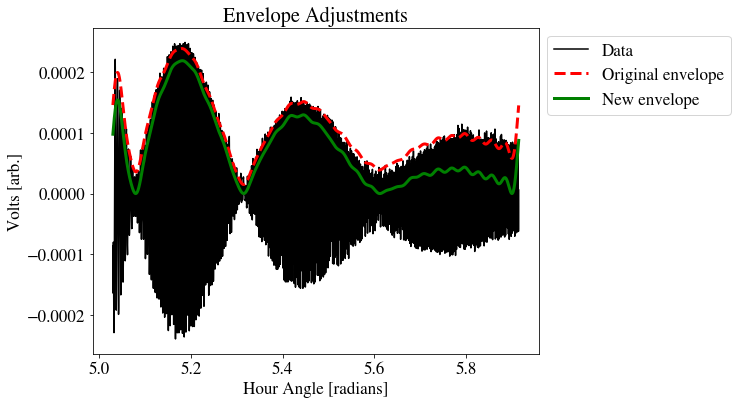

In [32]:
plt.figure(figsize=(8,6))
plt.plot(has, centered_volts, 'k', label='Data')
plt.plot(has, 1.575*abs_envelope, 'r--', lw=3, label='Original envelope')
plt.plot(has, 1.575*(abs_envelope-y_poly), 'g', lw=3, label='New envelope')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Volts [arb.]')
plt.xlabel('Hour Angle [radians]')
plt.title('Envelope Adjustments')
plt.show()

In [33]:
new_abs_envelope = (abs_envelope - y_poly)*1.575

chunk1_ = new_abs_envelope[0:local_mins[0]]
chunk1_ = chunk1_*-1
chunk2_ = new_abs_envelope[local_mins[0]:local_mins[1]]
chunk3_ = new_abs_envelope[local_mins[1]:local_mins[2]]
chunk3_ = chunk3_*-1
chunk4_ = new_abs_envelope[local_mins[2]:local_mins[3]]
chunk5_ = new_abs_envelope[local_mins[3]:]
chunk5_ = chunk5_*-1

new_envelope = np.append(chunk1_, chunk2_)
new_envelope = np.append(new_envelope, chunk3_)
new_envelope = np.append(new_envelope, chunk4_)
new_envelope = np.append(new_envelope, chunk5_)


has.shape, new_envelope.shape

((13500,), (13500,))

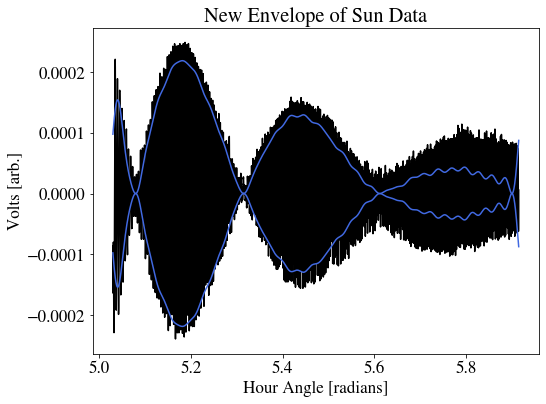

(0.0002187577078190824-1.2981170352849193e-21j)


In [34]:
plt.figure(figsize=(8,6))
plt.plot(has, centered_volts, 'k')
plt.plot(has, new_envelope, 'royalblue')
plt.plot(has, new_envelope*-1, 'royalblue')
plt.title('New Envelope of Sun Data')
plt.ylabel('Volts [arb.]')
plt.xlabel('Hour Angle [radians]')
plt.show()

print(max(new_envelope))

In [40]:
### Bessel Function Fitting ###

def bessel(ha, theta, A):
    c = 3e8 # m/s
    ν = 10.5e9 #Hz
    λ = c/ν
    delta = dec_rad
    d = 14.720 #m
    u = (d * np.cos(delta) * np.cos(ha)) / λ
    x = 2 * np.pi * theta * u
    return A * scipy.special.j1(x) / x

p0 = [0.003, 0.5]
pars, cov = scipy.optimize.curve_fit(bessel, has, new_envelope, p0)
θ_R , amp = pars

θ_D = 2*θ_R
print('Suns diameter [radians]:', θ_D)

θ_D_deg = (180/np.pi)*θ_D # Convert to degrees
print('Suns diameter [degrees]:', θ_D_deg)


Suns diameter [radians]: 0.007407599870976123
Suns diameter [degrees]: 0.424424208928585


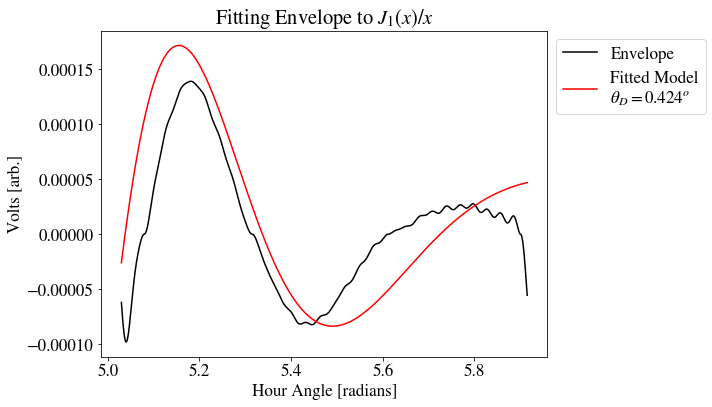

In [42]:
plt.figure(figsize=(8,6))

# plt.plot(has[752:10000], new_envelope[752:10000]/1.575, 'k', label='Envelope')
# plt.plot(has[752:10000], bessel(has[752:10000], *pars), 'r-', 
#          label='Fitted Model\n$\\theta_D={0:.3f}^o$'.format(θ_D_deg))

plt.plot(has, new_envelope/1.575, 'k', label='Envelope')
plt.plot(has, bessel(has, *pars), 'r-', 
         label='Fitted Model\n$\\theta_D={0:.3f}^o$'.format(θ_D_deg))
plt.title('Fitting Envelope to $J_1(x)/x$')
plt.xlabel('Hour Angle [radians]')
plt.ylabel('Volts [arb.]')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()